In [1]:
pip install -q pandas geopandas psycopg2-binary langchain_chroma geoalchemy2 fastkml shapely contextily langchainhub

Note: you may need to restart the kernel to use updated packages.


In [2]:
import psycopg2
from fastkml import kml
from shapely.geometry import shape
import json

# Define your database connection details
pg_host = 'localhost'
pg_port = '5432'
pg_name = 'postgres'
pg_user = 'hritik'
pg_password = ''
pg_database= 'hritik'

# KML file path
kml_file = "./karnataka.kml"

# Name for the new table in PostGIS
table_name = "karnataka"

# Monkey patch the Schema class to handle 'long' type
from fastkml.kml import Schema

original_append = Schema.append

def patched_append(self, type, name, displayName):
    if type == 'long':
        type = 'int'  # Map 'long' to 'int'
    return original_append(self, type, name, displayName)

Schema.append = patched_append

# Connect to PostgreSQL
conn = psycopg2.connect(host=pg_host, database=pg_database, user=pg_user, password=pg_password)
cur = conn.cursor()

# Enable PostGIS extension if not already enabled
cur.execute("CREATE EXTENSION IF NOT EXISTS postgis;")

# Create a new table for the KML data
cur.execute(f"""
    CREATE TABLE IF NOT EXISTS {table_name} (
        id SERIAL PRIMARY KEY,
        name VARCHAR(255),
        description TEXT,
        geom GEOMETRY
    );
""")

# Parse the KML file
with open(kml_file, 'rb') as kml_file:
    k = kml.KML()
    k.from_string(kml_file.read())

# Function to recursively extract features
def extract_features(element):
    if hasattr(element, 'features'):
        for feature in element.features():
            yield from extract_features(feature)
    else:
        yield element

# Function to safely get geometry WKT
def get_geometry_wkt(feature):
    if feature.geometry:
        try:
            # Convert the geometry to a GeoJSON-like dictionary
            geo_interface = feature.geometry.__geo_interface__
            # Use Shapely to convert from GeoJSON to WKT
            return shape(geo_interface).wkt
        except Exception as e:
            print(f"Error processing geometry: {e}")
            return None
    return None

# Insert features into the PostGIS table
for feature in extract_features(list(k.features())[0]):
    name = feature.name if feature.name else "Unknown"
    description = feature.description if feature.description else ""
    geom_wkt = get_geometry_wkt(feature)
    
    if geom_wkt:
        cur.execute(f"""
            INSERT INTO {table_name} (name, description, geom)
            VALUES (%s, %s, ST_GeomFromText(%s, 4326));
        """, (name, description, geom_wkt))

# Commit the changes and close the connection
conn.commit()
cur.close()
conn.close()

print(f"KML file successfully loaded into PostGIS table: {table_name}")

/Users/hritik/anaconda3/envs/huggingface/lib/python3.10/site-packages/fastkml/config.py:28: UserWarning: Package `lxml` missing. Pretty print will be disabled
  warnings.warn("Package `lxml` missing. Pretty print will be disabled")


KML file successfully loaded into PostGIS table: karnataka


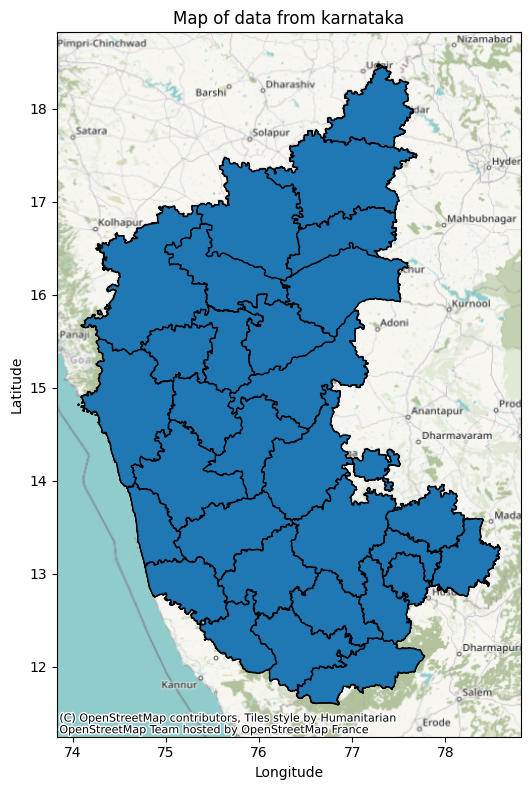

In [40]:
import geopandas as gpd
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

def plot_postgis_data(host, database, user, password, table_name):
    # Create a SQLAlchemy engine
    engine = create_engine(f'postgresql://{user}:{password}@{host}/{database}')

    # Read the data from PostGIS
    gdf = gpd.read_postgis(f"SELECT * FROM {table_name}", engine, geom_col='geom')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the data
    gdf.plot(ax=ax, edgecolor='black')

    # Add labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Map of data from {table_name}')

    # Add a basemap (optional, requires contextily)
    try:
        import contextily as ctx
        ctx.add_basemap(ax, crs=gdf.crs.to_string())
    except ImportError:
        print("Contextily not installed. Skipping basemap.")

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_postgis_data(pg_host,pg_database,pg_user, pg_password, table_name)

In [4]:
    # Create a SQLAlchemy engine
engine = create_engine(f'postgresql://{pg_user}:{pg_password}@{pg_host}/{pg_database}')

    # Read the data from PostGIS
gdf = gpd.read_postgis(f"SELECT * FROM {table_name}", engine, geom_col='geom')
gdf.head()

,id,name,description,geom
0,1,BAGALKOT,,"POLYGON Z ((75.42155 16.76763 0, 75.42117 16.7..."
1,2,BALLARI,,"POLYGON Z ((77.03527 15.8301 0, 77.03438 15.83..."
2,3,BELAGAVI,,"MULTIPOLYGON Z (((74.29117 15.83214 0, 74.2891..."
3,4,BENGALURU RURAL,,"POLYGON Z ((77.39863 13.49288 0, 77.39617 13.4..."
4,5,BENGALURU URBAN,,"POLYGON Z ((77.55164 13.23243 0, 77.55093 13.2..."


In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='llama3:8b-instruct-q8_0',base_url ="http://localhost:11434/v1")

In [6]:
from langchain_community.document_loaders import PyPDFLoader

file_path = (
    "./Volume-I_30-08-2020_compressed.pdf"
)
loader = PyPDFLoader(file_path)
pages = loader.load_and_split()

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(pages)

In [8]:
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceInferenceAPIEmbeddings

embeddings = HuggingFaceInferenceAPIEmbeddings(
    api_key='', model_name="sentence-transformers/all-MiniLM-l6-v2"
)

vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings,persist_directory='vectordb/')

In [141]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser

retriever = vectorstore.as_retriever()
prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

rag_output = rag_chain.invoke("are there any earthquake in karnataka?")

In [142]:
rag_output

'According to the context, the places that come under Seismic Zone III (Moderate Damage Risk Zone MSK VII) in Karnataka are:\n\n* Bidar\n* Gulbarga\n* Vijayapura\n* Bagalkot\n* Belagavi\n* Dharwad\n* Uttar Kannada\n* Shivamogga\n* Udupi\n* Dakshina Kannada\n* Kodagu'

In [143]:
from langchain_core.messages import HumanMessage, SystemMessage

messages = [
    SystemMessage(content="""
You are a geospatial data assistant. Based on the provided context, you need to generate a PostGIS query to retrieve polygon geometries for specific districts affected by landslides in Karnataka.

Table Name: karnataka
Columns:
name (text)
geom

Note: The district names are always in capital letters.

Task: Extract the names of the districts from the input and generate a PostGIS query to retrieve the polygon geometries for those districts.
    """),
    HumanMessage(content=rag_output),
]

result = llm.invoke(messages)

In [144]:
from langchain_core.output_parsers import StrOutputParser

parser = StrOutputParser()
output = parser.invoke(result)
print(output)

Based on the provided information, I will generate a PostGIS query to retrieve the polygon geometries for the districts affected by landslides in Karnataka.

Here is the PostGIS query:

```
SELECT name, geom 
FROM karnataka 
WHERE name IN ('BIDAR', 'GULBARGA', 'VIJAYAPURA', 'BAGALKOT', 'BELAGAVI', 'DHARWAD', 'UTTAR KANNADA', 'SHIVAMOGGA', 'UDUPI', 'DAKSHINA KANNADA', 'KODAGU');
```

This query will retrieve the names and corresponding polygon geometries for the districts specified in Seismic Zone III (Moderate Damage Risk Zone MSK VII) in Karnataka.


In [145]:
import re

def extract_postgis_query(text):
    # Define the patterns to extract the table name, column names, and district names
    table_pattern = re.compile(r"\bFROM\s+(\w+)\b", re.IGNORECASE)
    column_pattern = re.compile(r"\bSELECT\s+(.+?)\s+FROM\b", re.IGNORECASE | re.DOTALL)
    district_pattern = re.compile(r"\'([A-Z\s]+)\'")
    
    # Extract the SQL part of the text if present
    sql_start = text.find("SELECT")
    if sql_start != -1:
        sql_text = text[sql_start:]
    else:
        sql_text = text

    # Search for the table name and column names in the SQL text
    table_match = table_pattern.search(sql_text)
    column_match = column_pattern.search(sql_text)
    
    # Find all district names in the entire text
    district_matches = district_pattern.findall(text)
    
    if not table_match or not column_match or not district_matches:
        return None

    table_name = table_match.group(1)
    column_names = column_match.group(1).strip()
    districts = ", ".join([f"'{district}'" for district in district_matches])
    
    # Construct the PostGIS query
    query = f"SELECT {column_names} FROM {table_name} WHERE name IN ({districts});"
    
    return query

In [146]:
query = extract_postgis_query(output)
print(query)

SELECT name, geom FROM karnataka WHERE name IN ('BIDAR', 'GULBARGA', 'VIJAYAPURA', 'BAGALKOT', 'BELAGAVI', 'DHARWAD', 'UTTAR KANNADA', 'SHIVAMOGGA', 'UDUPI', 'DAKSHINA KANNADA', 'KODAGU');


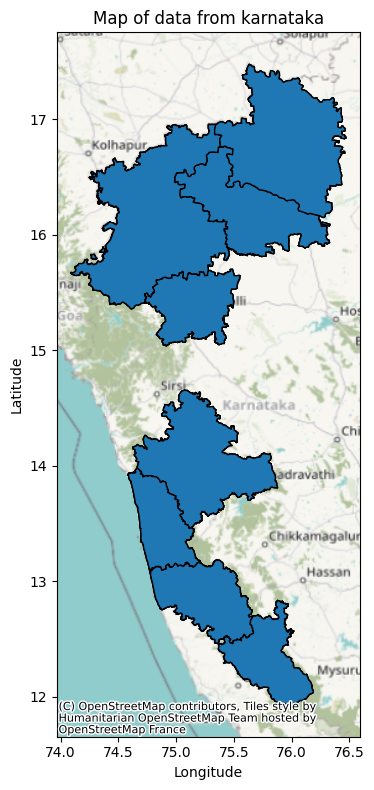

In [140]:
engine = create_engine(f'postgresql://{pg_user}:{pg_password}@{pg_host}/{pg_database}')

gdf = gpd.read_postgis(query, engine, geom_col='geom')

fig, ax = plt.subplots(figsize=(12, 8))

gdf.plot(ax=ax, edgecolor='black')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Map of data from {table_name}')

try:
    import contextily as ctx
    ctx.add_basemap(ax, crs=gdf.crs.to_string())
except ImportError:
    print("Contextily not installed. Skipping basemap.")

plt.tight_layout()
plt.show()

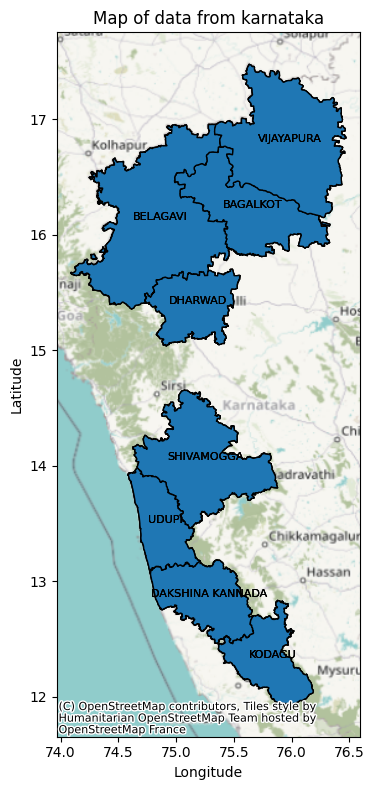

In [154]:
engine = create_engine(f'postgresql://{pg_user}:{pg_password}@{pg_host}/{pg_database}')
gdf = gpd.read_postgis(query, engine, geom_col='geom')

fig, ax = plt.subplots(figsize=(12, 8))
gdf.plot(ax=ax, edgecolor='black')

# Add labels for each district
for idx, row in gdf.iterrows():
    if 'geometry' in gdf.columns:
        geometry = row['geometry']
    elif 'geom' in gdf.columns:
        geometry = row['geom']
    else:
        print("No geometry column found. Please check your GeoDataFrame.")
        break
    
    centroid = geometry.centroid
    if 'name' in gdf.columns:
        label = row['name']
    else:
        print("No 'name' column found. Using index as label.")
        label = str(idx)
    
    ax.annotate(text=label, xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=8, ha='center', va='center')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Map of data from {table_name}')

try:
    import contextily as ctx
    ctx.add_basemap(ax, crs=gdf.crs.to_string())
except ImportError:
    print("Contextily not installed. Skipping basemap.")

plt.tight_layout()
plt.savefig('map')
plt.show()